In [21]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [19]:
from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig,
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig


Pipeline.from_configs(
    context=ProcessorConfig(),
    indexer_config=LocalIndexerConfig(input_path="./NetSol.pdf"),
    downloader_config=LocalDownloaderConfig(),
    source_connection_config=LocalConnectionConfig(),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=os.getenv("UNSTRUCTURED_API_KEY"),
        partition_endpoint=os.getenv("UNSTRUCTURED_API_URL"),
        strategy="hi_res",
        additional_partition_args={
            "split_pdf_page": True,
            "split_pdf_allow_failed": True,
            "split_pdf_concurrency_level": 15,
            "extract_tables_spreadsheet": True,
            "extract_tables": True,
            "infer_table_structure": True,
            "ocr_languages": ["eng"],
        },
    ),
    uploader_config=LocalUploaderConfig(output_dir="./output"),
).run()

Overriding of current TracerProvider is not allowed
2024-12-12 01:50:49,739 MainProcess INFO     created index with configs: {"input_path": "NetSol.pdf", "recursive": false}, connection configs: {"access_config": "**********"}
2024-12-12 01:50:49,740 MainProcess INFO     Created download with configs: {"download_dir": null}, connection configs: {"access_config": "**********"}
2024-12-12 01:50:49,741 MainProcess INFO     created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": {"split_pdf_page": true, "split_pdf_allow_failed": true, "split_pdf_concurrency_level": 15, "extract_tables_spreadsheet": true, "extract_tables": true, "infer_table_structure": true, "ocr_languages": ["eng"]}, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "element_exclude": [], "metadata_include": [], "partition_endpoint": "https://api.

In [47]:
import json
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter


def load_unstructured_documents():
    documents = []
    output_dir = Path("./output")

    for file_path in output_dir.glob("*.json"):
        with open(file_path, "r") as f:
            content = json.load(f)

            for element in content:
                if element.get("text"):
                    documents.append(element["text"])

    return documents


def create_chunks(documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
    )
    chunks = text_splitter.create_documents(documents)
    return chunks


documents = load_unstructured_documents()
chunks = create_chunks(documents)

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [3]:
from pinecone.grpc import PineconeGRPC as Pinecone


pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])
index = pc.Index('itu')

# for counter, chunk in enumerate(chunks):
#     print(f'Processing chunk {counter}')

#     embeddings = model.encode(chunk.page_content)

#     data = {
#         'id': str(counter),
#         'values': embeddings,
#         'metadata': {'text': chunk.page_content}
#     }

#     index.upsert([data])

In [4]:
from langchain_groq import ChatGroq

In [44]:
router_prompt = """Given a user question, classify it into one of these categories:
- FINANCIAL: Questions about NetSol's financial information, revenue, profits, etc.
- CURRENT: Questions about current events, real-time information, or something that may have happened or changed recently
- GENERAL: Anything that does not fall into the other categories

Output only one category: FINANCIAL, CURRENT, or GENERAL

Question: {question}
Category:"""


def route_query(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        temperature=0,
        max_tokens=8,
    )

    question = state["messages"][0].content

    formatted_prompt = router_prompt.format(question=question)

    category = chat_model.invoke(formatted_prompt)

    return {"category": category.content}

In [45]:
from langchain_core.runnables import (
    RunnableLambda,
    RunnablePassthrough,
    RunnableParallel,
)


def get_context(query: str, k: int = 3) -> str:
    matches = index.query(vector=model.encode(query), top_k=k, include_metadata=True)

    context_chunks = [match["metadata"]["text"] for match in matches["matches"]]

    context = ""

    for counter, chunk in enumerate(context_chunks):
        context += f"## Chunk {counter}:\n\n{chunk}\n\n"

    return context


retrieval_chain = RunnableParallel(
    {"context": RunnableLambda(get_context), "query": RunnablePassthrough()}
)


def retrieve_documents(state):
    question = state["messages"][-1].content

    context = retrieval_chain.invoke(question)

    return {"context": context}

In [46]:
grade_prompt = """You are trying analyze if the provided documents are relevant to the user question or not. If they are releavant you will output generate, if they are not you will output rewrite.

Output only one word: GENERATE or REWRITE

Provided documents:
{context}                          

Question:
{question}
"""


def grade_documents(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        temperature=0,
        max_tokens=8,
    )

    question = state["messages"][-1].content
    context = state["context"]

    formatted_prompt = grade_prompt.format(context=context, question=question)

    response = chat_model.invoke(formatted_prompt)

    if response.content == "REWRITE":
        return {"context": None}
    else:
        return {"context": context}

In [47]:
rewrite_prompt = """Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question: {question} 

I ONLY WANT THE REWRITTEN QUESTION, NO OTHER TEXT."""


def rewrite_query(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        max_tokens=4096,
    )

    question = state["messages"][-1].content

    formatted_prompt = rewrite_prompt.format(question=question)

    response = chat_model.invoke(formatted_prompt)

    return {"messages": [response.content]}


In [48]:
def handle_financial(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        max_tokens=4096,
    )

    question = state["messages"][-1].content

    context = state["context"]

    if context is None:
        return {"messages": ["No context found"]}

    prompt = f"""You are a financial expert assistant. Answer the following question using the provided context.
    If you cannot find the answer in the context, say so.
    
    Question: {question}
    Context: {context}
    Answer:"""

    response = chat_model.invoke(prompt)

    return {"messages": [response.content]}

In [49]:
from langchain_community.tools import TavilySearchResults

tavily = TavilySearchResults()


def handle_current(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        max_tokens=4096,
    )

    question = state["messages"][-1].content

    search_results = tavily.invoke(question)
    
    context = ""

    for counter, chunk in enumerate(search_results):
        context += f"## Chunk {counter}:\n\n{chunk}\n\n"

    prompt = f"""You are a helpful assistant. Answer the following question using the search results.
    Base your answer only on the provided search results.
    
    Question: {question}
    Search Results: {context}
    Answer:"""

    response = chat_model.invoke(prompt)

    return {"messages": [response.content], "context": context}

In [50]:
def handle_general(state):
    chat_model = ChatGroq(
        model_name="llama3-8b-8192",
        max_tokens=4096,
    )

    question = state["messages"][-1].content

    prompt = f"""You are an expert on every topic. Answer the following question.
    Question: {question}
    Answer:"""

    response = chat_model.invoke(prompt)

    return {"messages": [response.content]}

In [51]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    category: str | None
    context: str | None


workflow = StateGraph(AgentState)

workflow.add_node("router", route_query)
workflow.add_node("financial", handle_financial)
workflow.add_node("current", handle_current)
workflow.add_node("general", handle_general)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("rewrite", rewrite_query)
workflow.add_node("grade_documents", grade_documents)

workflow.add_edge(START, "router")

workflow.add_conditional_edges(
    "router",
    lambda x: x["category"],
    {
        "FINANCIAL": "retrieve",
        "CURRENT": "current",
        "GENERAL": "general",
    },
)

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    lambda x: "REWRITE" if x["context"] is None else "FINANCIAL",
    {
        "REWRITE": "rewrite",
        "FINANCIAL": "financial",
    },
)

workflow.add_edge("rewrite", "router")

workflow.add_edge("financial", END)
workflow.add_edge("current", END)
workflow.add_edge("general", END)

chain = workflow.compile()

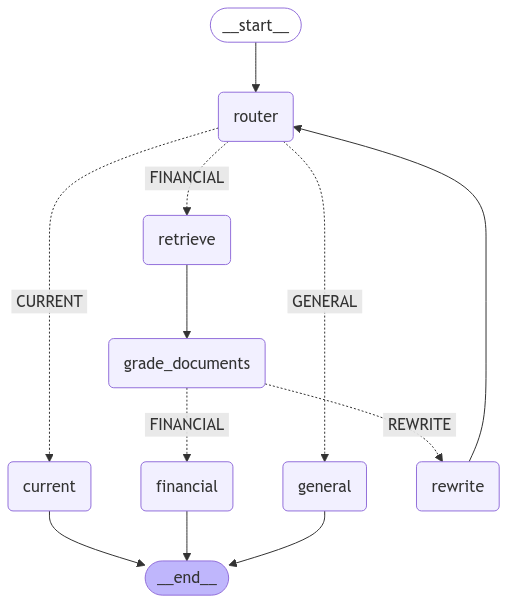

In [13]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [55]:
def process_query(question: str) -> str:
    inputs = {
        "messages": [
            ("user", question),
        ]
    }

    response = chain.invoke(inputs)
    
    return response


questions = [
    "What was NetSol's revenue in 2024?",
    "What are the current market trends in the automotive industry?",
    "Tell me about NetSol's products and services.",
]

for question in questions:
    response = process_query(question)
    
    print("\nQuestion: ", response["messages"][0].content)
    print("Category: ", response["category"])
    print("Answer: ", response["messages"][-1].content)



Question:  What was NetSol's revenue in 2024?
Category:  FINANCIAL
Answer:  According to the context, NetSol's revenue in 2024 was PKR 9,580 million.

Question:  What are the current market trends in the automotive industry?
Category:  CURRENT
Answer:  Based on the search results, the current market trends in the automotive industry include:

1. Electric Vehicle (EV) adoption increases worldwide, with BEV market share expected to rise to 16.2% in 2023.
2. Autonomous Vehicles (AVs) are set to disrupt the auto industry, with companies like TuSimple leading the way in autonomous trucking.
3. Electrification is a growing trend, with many car manufacturers shifting towards electric vehicles.
4. The increasing role of software is a significant trend, with automation and connectivity becoming more prevalent in vehicles.
5. Concerns about the environment and climate are driving innovation and investment in the industry.
6. Sales for BEV and PHEV in Europe increased by 137% in 2020 compared wi

In [15]:
from datasets import Dataset

import json


def load_evaluation_data(json_path="qa.json"):
    with open(json_path, "r") as f:
        qa_pairs = json.load(f)

    questions = [pair["question"] for pair in qa_pairs]
    ground_truth = [pair["answer"] for pair in qa_pairs]

    return questions, ground_truth


def get_eval_dataset():
    questions, ground_truth = load_evaluation_data()

    contexts = []
    generated_answers = []

    for question in questions:
        response = chain.invoke(
            {
                "messages": [
                    ("user", question),
                ]
            }
        )

        answer = response["messages"][-1].content

        context = response.get("context", {})
        if isinstance(context, dict):
            context_str = context.get("context", "")
        else:
            context_str = str(context)

        contexts.append([context_str])
        generated_answers.append(answer)

    eval_dataset = Dataset.from_dict(
        {
            "user_input": questions,
            "retrieved_contexts": contexts,
            "response": generated_answers,
            "reference": ground_truth,
        }
    )
    
    return eval_dataset
    

eval_dataset = get_eval_dataset()

In [25]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=os.environ['HF_API_KEY'])

messages = [
	{
		"role": "user",
		"content": "What is the capital of France?"
	}
]

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-0.5B-Instruct", 
	messages=messages, 
	max_tokens=500
)

print(completion.choices[0].message)

ChatCompletionOutputMessage(role='assistant', content='The capital of France is Paris.', tool_calls=None)


In [37]:
from langchain.llms.base import LLM
from typing import Any, List, Optional
from pydantic import Field


class HuggingFaceInferenceLLM(LLM):
    client: Any = Field(description="HuggingFace InferenceClient")

    def __init__(self, client):
        super().__init__(client=client)

    def _call(self, prompt: str, *args, **kwargs) -> str:
        messages = [{"role": "user", "content": prompt}]

        completion = self.client.chat.completions.create(
            model="Qwen/Qwen2.5-0.5B-Instruct",
            messages=messages,
            max_tokens=500,
            temperature=kwargs.get("temperature", 0.7),
        )

        return completion.choices[0].message.content

    @property
    def _llm_type(self) -> str:
        return "huggingface_inference"

In [56]:
from langchain_openai import ChatOpenAI

from ragas import evaluate
from ragas.metrics import (
    AnswerCorrectness,
    Faithfulness,
)

from ragas.llms import LangchainLLMWrapper

# custom_llm = HuggingFaceInferenceLLM(client)
# evaluator_llm = LangchainLLMWrapper(custom_llm)

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model_name="gpt-4o-mini"))

new_eval_dataset = Dataset.from_dict(eval_dataset[0:1])

def evaluate_rag_system():
    metrics = [
        AnswerCorrectness(llm=evaluator_llm),
        Faithfulness(llm=evaluator_llm),
    ]

    results = evaluate(
        new_eval_dataset,
        metrics=metrics,
    )

    return results


results = evaluate_rag_system()
print(results)


In [42]:
import gradio as gr


def chat_interface(message):
    response = process_query(message)

    category = response["category"]
    answer = response["messages"][-1].content

    return f"Category: {category}\n\nAnswer: {answer}"


demo = gr.Interface(
    fn=chat_interface,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
    outputs=gr.Textbox(lines=10, label="Response"),
    title="NetSol Q&A System",
    description="Ask questions about NetSol's financial information, current events, or general topics.",
    examples=[
        ["What was NetSol's revenue in 2024?"],
        ["What are the current market trends in the automotive industry?"],
        ["Tell me about NetSol's products and services."],
    ],
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
